In [1]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
##Reading in the dataset
df = pd.read_csv("cleaned_dataset.csv")
print(df.shape)
df.info()

(10000, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   transaction_id               10000 non-null  object 
 1   country                      10000 non-null  object 
 2   amount_usd                   10000 non-null  float64
 3   transaction_type             10000 non-null  object 
 4   date_of_transaction          10000 non-null  object 
 5   person_involved              10000 non-null  object 
 6   industry                     10000 non-null  object 
 7   destination_country          10000 non-null  object 
 8   reported_by_authority        10000 non-null  bool   
 9   source_of_money              10000 non-null  object 
 10  money_laundering_risk_score  10000 non-null  int64  
 11  shell_companies_involved     10000 non-null  int64  
 12  financial_institution        10000 non-null  object 
 13  tax_h

In [3]:
#Dropping columns
df.drop(columns=["date_of_transaction", "person_involved", "financial_institution", "year","transaction_id"], inplace=True)
df.head()

,country,amount_usd,transaction_type,industry,destination_country,reported_by_authority,source_of_money,money_laundering_risk_score,shell_companies_involved,tax_haven_country,month
0,Brazil,3.267530e+06,Offshore Transfer,Construction,USA,True,Illegal,6,1,Singapore,1
1,China,4.965767e+06,Stocks Transfer,Luxury Goods,South Africa,False,Illegal,9,0,Bahamas,1
2,UK,9.416750e+04,Stocks Transfer,Construction,Switzerland,True,Illegal,1,3,Switzerland,1
3,UAE,3.864201e+05,Cash Withdrawal,Oil & Gas,Russia,False,Illegal,7,2,Panama,1
4,South Africa,6.433784e+05,Cryptocurrency,Real Estate,USA,True,Illegal,1,9,Luxembourg,1


In [4]:
df["source_of_money"] = df.source_of_money.apply(lambda x: 1 if x == 'Illegal' else 0)
df["reported_by_authority"] = df.source_of_money.apply(lambda x: 1 if x == True else 0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   country                      10000 non-null  object 
 1   amount_usd                   10000 non-null  float64
 2   transaction_type             10000 non-null  object 
 3   industry                     10000 non-null  object 
 4   destination_country          10000 non-null  object 
 5   reported_by_authority        10000 non-null  int64  
 6   source_of_money              10000 non-null  int64  
 7   money_laundering_risk_score  10000 non-null  int64  
 8   shell_companies_involved     10000 non-null  int64  
 9   tax_haven_country            10000 non-null  object 
 10  month                        10000 non-null  int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 859.5+ KB


In [7]:
# Define Preprocessing Pipelines

# Define preprocessing for numeric features 
numeric_features = ['amount_usd', 'money_laundering_risk_score', 'shell_companies_involved']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (Pclass, Embarked) 
categorical_features = ['country', 'transaction_type', 'industry', 'destination_country', 'tax_haven_country']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Combine preprocessing for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        # ('binary', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features)])

In [8]:
# Correlation Analysis (this is optional and not needed for the ML Experiment)
# It just shows what the data looks like after transformation before training
# We will still declare a full pipeline of preprocessing + training

# Use only preprocessing pipeline to transform the data
preprocessed_X_train = preprocessor.fit_transform(df)

# Convert preprocessed data to a DataFrame
# Get the feature names after one-hot encoding
encoded_feature_names = (numeric_features + list(preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)))


df_final = pd.DataFrame(preprocessed_X_train, columns= encoded_feature_names)
df_final["source_of_money"] = df.source_of_money
df_final["month"] = df.month
df_final["reported_by_authority"] = df.reported_by_authority
df_final.head()

,amount_usd,money_laundering_risk_score,shell_companies_involved,country_Brazil,country_China,country_India,country_Russia,country_Singapore,country_South Africa,country_Switzerland,country_UAE,country_UK,country_USA,transaction_type_Cash Withdrawal,transaction_type_Cryptocurrency,transaction_type_Offshore Transfer,transaction_type_Property Purchase,transaction_type_Stocks Transfer,industry_Arms Trade,industry_Casinos,industry_Construction,industry_Finance,industry_Luxury Goods,industry_Oil & Gas,industry_Real Estate,destination_country_Brazil,destination_country_China,destination_country_India,destination_country_Russia,destination_country_Singapore,destination_country_South Africa,destination_country_Switzerland,destination_country_UAE,destination_country_UK,destination_country_USA,tax_haven_country_Bahamas,tax_haven_country_Cayman Islands,tax_haven_country_Luxembourg,tax_haven_country_Panama,tax_haven_country_Singapore,tax_haven_country_Switzerland,source_of_money,month,reported_by_authority
0,0.537609,0.163680,-1.204808,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1
1,1.729945,1.200501,-1.552075,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1,1
2,-1.690418,-1.564356,-0.510274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,1
3,-1.485226,0.509287,-0.857541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1
4,-1.304815,-1.564356,1.573328,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1


In [9]:
# Function for Classification
# THE ROC CURVE CODE WILL BREAK FOR MULTI_CLASS PROBLEMS
def doClassification(model, X_train, X_test, y_train, y_test):
    # Step 3: Fit the model
    model.fit(X_train, y_train)
    
    # Step 4: Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Generate metrics TRAIN
    train_cf = confusion_matrix(y_train, train_preds)
    train_cr = classification_report(y_train, train_preds)
    train_auc = roc_auc_score(y_train, train_proba)
    
    train_results = f"""TRAIN METRICS
    Confusion Matrix: 
    {train_cf}
    
    AUC: {train_auc}

    Classification Report:
    {train_cr}
    """
    
    print(train_results)

    # Generate metrics TEST
    test_cf = confusion_matrix(y_test, test_preds)
    test_cr = classification_report(y_test, test_preds)
    test_auc = roc_auc_score(y_test, test_proba)
    
    test_results = f"""TEST METRICS
    Confusion Matrix: 
    {test_cf}
    
    AUC: {test_auc}

    Classification Report:
    {test_cr}
    """
    
    print(test_results)

    # VISUALIZE TEST RESULTS
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(test_cf, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test.values, test_proba)
    
    # Set figure size
    plt.figure(figsize=(6, 6))
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.2f})')
    
    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    
    # Titles and labels
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Add grid and legend
    plt.grid(linestyle="--", color="lightgrey", alpha=0.75)
    plt.legend(loc="lower right")
    
    # Display the plot
    plt.show()

TRAIN METRICS
    Confusion Matrix: 
    [[2225    0]
 [   0 5275]]
    
    AUC: 1.0

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00      2225
           1       1.00      1.00      1.00      5275

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

    
TEST METRICS
    Confusion Matrix: 
    [[  63  695]
 [ 158 1584]]
    
    AUC: 0.4974735617629329

    Classification Report:
                  precision    recall  f1-score   support

           0       0.29      0.08      0.13       758
           1       0.70      0.91      0.79      1742

    accuracy                           0.66      2500
   macro avg       0.49      0.50      0.46      2500
weighted avg       0.57      0.66      0.59      2500

    


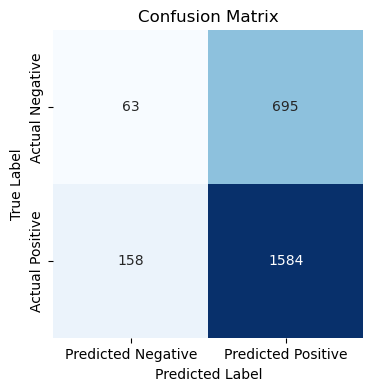

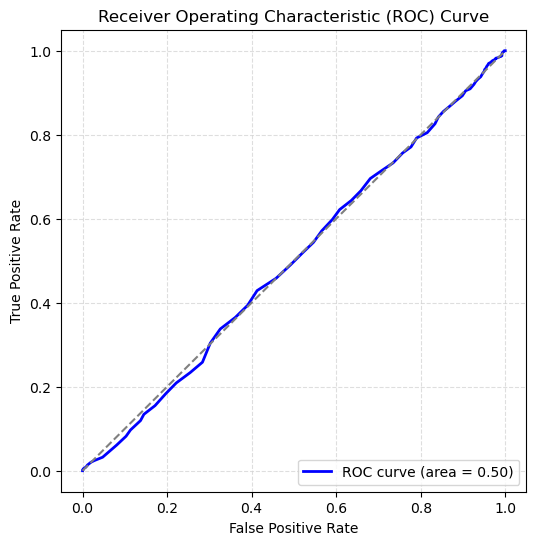

In [24]:
# Step 2: Init the Model
et = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier(random_state=42))
])

X = df.drop(columns=["source_of_money"])
y = df.source_of_money


# sm = SMOTE(random_state =42)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) # stratify=True maintains target class percentages
# X_train, y_train = sm.fit_resample(X_train, y_train)

# Do Machine Learning
doClassification(et, X_train, X_test, y_train, y_test)

In [25]:
# Model
import pickle

pickle.dump(et, open("black_money_model_pipeline.h5", 'wb'))